## University of Bari Aldo Moro
Master Degree in <b>Computer Science</b> - <b>Computer Vision Course</b><br>

### Vision Transformer for Unmanned Aerial Vehicles Agronomic Research
- [Dependencies](#dependencies)
- [Paths](#paths)
- [Parameters](#parameters)
- [Preprocessing](#preprocessing)
    - [Ground Truth](#ground-truth)
    - [GCP Finder](#gcp_finder)
    - [Plots Clipper](#plots_clipper)
- [Dataset](#dataset)
- [Model](#model)
    - [Training](#training)
    - [Evaluation](#evaluation)
    - [Inference](#inference)

### Dependencies
<a name='dependencies'></a>

In [1]:
# %pip install git+https://github.com/PyTorchLightning/pytorch-lightning

In [2]:
# Libraries

from argparse import ArgumentParser
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateFinder
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.models import get_model, ViT_B_32_Weights, ViT_B_16_Weights, ViT_L_16_Weights
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import mlflow.pytorch
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torchvision
torchvision.disable_beta_transforms_warning()

d:\Repository\UAV_ViT\venv\lib\site-packages\pydantic\_internal\_fields.py:127: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
d:\Repository\UAV_ViT\venv\lib\site-packages\pydantic\_internal\_config.py:269: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)
d:\Repository\UAV_ViT\venv\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we

In [3]:
# Import from notebooks

import import_ipynb

from notebooks.gcp_finder import *
from notebooks.clipper import *
from notebooks.dataset import *
from notebooks.vit import *
from notebooks.visualization import *

importing Jupyter notebook from d:\Repository\UAV_ViT\notebooks\gcp_finder.ipynb
importing Jupyter notebook from d:\Repository\UAV_ViT\notebooks\clipper.ipynb
importing Jupyter notebook from d:\Repository\UAV_ViT\notebooks\dataset.ipynb
importing Jupyter notebook from d:\Repository\UAV_ViT\notebooks\vit.ipynb
importing Jupyter notebook from d:\Repository\UAV_ViT\notebooks\visualization.ipynb


In [5]:
# Cuda setup

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used", device)
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead", device)

GPU is available and being used cuda


#### Paths
<a name="paths"></a>

In [4]:
# Paths

DATASET_PATH = "./data/dataset"
PLOT_PATH = "./data/plots"
SAMPLES_PATH = "./data/raw_samples"
VISUALS_PATH = "./data/visuals"
SHAPEFILE_PATH = "./data/shapefile/all_plots.shp"
ORTHOMOSAIC_PATH = "./data/orthophoto/raster.tif"
GCP_PATH = "./data/GCP_Images"
GROUND_TRUTH_PATH = './data/ground_truth/corn_plant_height_ground_truth.xlsx'
MODEL_PATH = "./data/models/"
CHECKPOINT_PATH = "./data/checkpoints/"

### Parameters
<a name='parameters'></a>

In [ ]:
# Parameters

TEST_SIZE = 0.2 # % of dataset
VAL_SIZE = 0.2  # % of training set

MAX_EPOCS = -1
BATCH_SIZE = 8
WORKERS = 8
IMG_SIZE = (224,224)

BACKBONES = [
    {'name': "vit_b_16", 'weights': ViT_B_16_Weights.DEFAULT}, # default ImageNet on DeIT recipe
    {'name': "vit_b_16", 'weights': ViT_B_16_Weights.IMAGENET1K_SWAG_LINEAR_V1},
    {'name': "vit_b_32", 'weights': ViT_B_32_Weights.DEFAULT},
    {'name': "vit_l_16", 'weights': ViT_L_16_Weights.DEFAULT}, # recipe https://github.com/pytorch/vision/tree/main/references/classification#vit_l_16
    {'name': "vit_l_16", 'weights': ViT_L_16_Weights.IMAGENET1K_SWAG_LINEAR_V1},
    {'name': "vit_l_32", 'weights': ViT_L_16_Weights.DEFAULT},
]
BACKBONE = BACKBONES[2]

FROZEN_LAYERS = 6

ES_PATIENCE = 30
ES_STOPPING_THRESHOLD = 1e-4
ES_DIVERGENCE_THRESHOLD = 5

LR_FINDER = True
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-1
DROPOUT = 0.1
ATTENTION_DROPOUT = 0

## Preprocessing
<a name='preprocessing'></a>

#### Ground truth
<a name="ground_truth"></a>

In [6]:
# Loading the ground truth
df = pd.read_excel(GROUND_TRUTH_PATH)

# Elevation format conversion to float32
df["elevation"] = df["Elev maximum (m)"].astype("float32")
df.head()

,Barcode,Test,DataFile 3,Plot,Range,Row,Rep,Entry,Stock,Pedigree,PHT (in),PHT(m),Elev maximum (m),elevation
0,CS15-2A2B-001,2A2B,2A2B_1.las,1,12,264,1,e061,CS14-YBCB-25-X-POL-D2,(LAMA2002-23-1-B-B/LAMA2002-11-1-B-B)-B-B-B-B-...,85,2.1590,2.80,2.80
1,CS15-2A2B-002,2A2B,2A2B_2.las,2,12,262,1,e031,CS14-POL-X8-X-YBCB-03,LH195RR2/(LAMA2002-23-3-B/LAMA2002-58-4-B)-B-B...,85,2.1590,2.86,2.86
2,CS15-2A2B-003,2A2B,2A2B_3.las,3,12,260,1,e096,CS14-ISO195-029-X-POL-G8,(LAMA2002-22-1-B-B-B-B/LAMA2002-1-5-B-B-B-B)-2...,84,2.1336,2.69,2.69
3,CS15-2A2B-004,2A2B,2A2B_4.las,4,12,258,1,e007,Check 7 - BH 8732VTTP (2015),Check 7 - BH 8732VTTP (2015),93,2.3622,2.64,2.64
4,CS15-2A2B-005,2A2B,2A2B_5.las,5,12,256,1,e088,CS14-POL-B6-X-YBCB-11,GP7169GT/(LAMA2002-22-1-B-B-B-B/LAMA2002-10-1-...,81,2.0574,2.65,2.65


In [7]:
# Ground Truth Preprocessing

def renaming(filename):
    return filename[:-4] + ".png"

df["filename"] = df["DataFile 3"].apply(renaming)
df[['filename', 'elevation']].head()

,filename,elevation
0,2A2B_1.png,2.80
1,2A2B_2.png,2.86
2,2A2B_3.png,2.69
3,2A2B_4.png,2.64
4,2A2B_5.png,2.65


In [8]:
# Targets normalization

scaler = MinMaxScaler()
df["elevation"] = scaler.fit_transform(df[["elevation"]])

In [9]:
# Scaled targets

df[['filename', 'elevation']].head()

,filename,elevation
0,2A2B_1.png,0.606838
1,2A2B_2.png,0.632479
2,2A2B_3.png,0.559829
3,2A2B_4.png,0.538462
4,2A2B_5.png,0.542735


#### Ground Control Point (GCP) Finder

<a name='gcp_finder'></a>

In [10]:
# gcp_finder = GCPFinder(DATASET_PATH, GCP_PATH)
# gcp_finder.gcp_mover()

#### Plots Clipper
<a name='plots_clipper'></a>

In [11]:
# clipper = Clipper(ORTHOMOSAIC_PATH, SHAPEFILE_PATH, PLOT_PATH)
# clipper.start()

## Dataset
<a name="dataset"></a>

In [14]:
# Datasets definition

dataset = PlotsDataset(labels=df, img_dir=PLOT_PATH, img_size=IMG_SIZE, transforms=None)

print(f"Dataset length: {len(dataset)}")
print(f"Image type: {type(dataset[0][0])}")
print(f"Image shape: {dataset[0][0].shape})")
print(f"Label type: {type(dataset[0][1])}")

Dataset length: 705
Image type: <class 'torch.Tensor'>
Image shape: torch.Size([3, 224, 224]))
Label type: <class 'numpy.float32'>


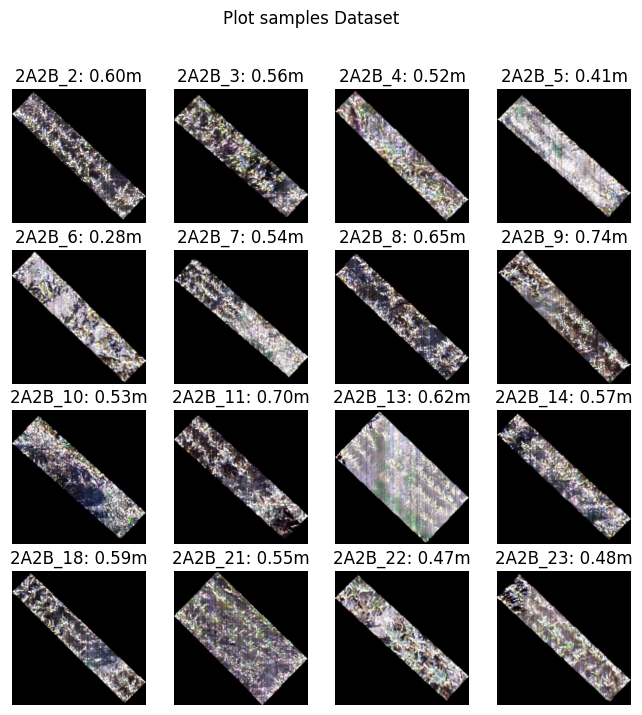

In [15]:
# Dataset samples

dataset.show_samples(df['elevation'], "Dataset")

Text(0.5, 1.0, 'Distribution of pixels')

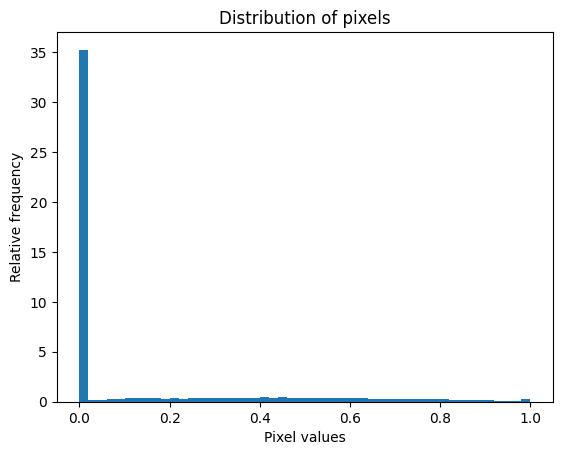

In [16]:
# Pixel distribution

plt.hist(dataset[0][0].permute(1,2,0).ravel(), bins=50, density=True)
plt.xlabel("Pixel values")
plt.ylabel("Relative frequency")
plt.title("Distribution of pixels")

In [17]:
# Datasets means and stds

means, stds = dataset.get_means_stds()
print(f'Dataset means: {means}\nstds: {stds}')

Dataset means: [0.16330452263355255, 0.15598873794078827, 0.1589348316192627]
stds: [0.2748134136199951, 0.2666980028152466, 0.26911261677742004]


In [18]:
# Dataset split

train_set, test_set = train_test_split(dataset, test_size=TEST_SIZE)
train_set, val_set = train_test_split(train_set, test_size=VAL_SIZE)

print(f"Training set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_set)}")

Training set size: 451
Validation set size: 113
Test set size: 141


In [19]:
# Dataloaders

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=WORKERS)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, num_workers=WORKERS)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=WORKERS)

print(f"Train Dataloader size: {len(train_loader)}")
print(f"Validation Dataloader size: {len(val_loader)}")
print(f"Test Dataloader size: {len(test_loader)}")

Train Dataloader size: 57
Validation Dataloader size: 15
Test Dataloader size: 18


## Model
<a name='model'></a>

In [20]:
# Backbone

backbone = get_model(BACKBONE['name'], weights=BACKBONE['weights'])
backbone.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [21]:
# Vargs setup

def setup_vargs(lr = LEARNING_RATE):
    parser = ArgumentParser()
    parser.add_argument('--learning_rate', type=float, default=lr)
    parser.add_argument('--weight_decay', type=float, default=WEIGHT_DECAY)
    parser.add_argument('--batch_size', type=int, default=BATCH_SIZE)
    parser.add_argument('--no_grad_layers_n', type=int, default=FROZEN_LAYERS)
    parser.add_argument('--dropout', type=float, default=DROPOUT)
    parser.add_argument('--attention_dropout', type=float, default=ATTENTION_DROPOUT)

    args, _ = parser.parse_known_args()

    vargs = vars(args)
    return vargs

vargs = setup_vargs()

In [22]:
# MLFlow init

mlflow.pytorch.autolog() 
mlflow.start_run()

run = mlflow.active_run()
log_run_id = run.info.run_id
print(f"Active run_id: {run.info.run_id}")

Active run_id: b71217073c794a4990194689e35bdc2d


In [23]:
# Model

model = UAV_vit(backbone, **vargs)

In [24]:
model.backbone.heads

Sequential(
  (head): Linear(in_features=768, out_features=1, bias=True)
)

### Training
<a name='training'></a>

In [25]:
# Callbacks

learning_rate_finder_cb = LearningRateFinder(num_training_steps=200)
checkpoint_cb = ModelCheckpoint(dirpath=CHECKPOINT_PATH, save_top_k=1, monitor="val_loss", mode="min", filename="uav_vit-{epoch:02d}-{val_loss:.3f}")
earlyStopping_cb = EarlyStopping(monitor="val_loss", patience=ES_PATIENCE, stopping_threshold=ES_STOPPING_THRESHOLD, divergence_threshold=ES_DIVERGENCE_THRESHOLD, mode="min")

callbacks = [earlyStopping_cb, checkpoint_cb]
if LR_FINDER:
    callbacks.append(learning_rate_finder_cb)

In [26]:
# Trainer

trainer = pl.Trainer(
    # log_every_n_steps=1,
    max_epochs=MAX_EPOCS,
    callbacks=callbacks,
    num_sanity_val_steps=0,
    enable_checkpointing=True,
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [27]:
# Fit

trainer.fit(model, train_loader, val_loader)

d:\Repository\UAV_ViT\venv\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:617: UserWarning: Checkpoint directory D:\Repository\UAV_ViT\data\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/200 [00:00<?, ?it/s]

LR finder stopped early after 184 steps due to diverging loss.
Learning rate set to 1.9054607179632475e-07
INFO: Restoring states from the checkpoint path at d:\Repository\UAV_ViT\.lr_find_151acc78-e631-45f1-906e-06d0c140d69b.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at d:\Repository\UAV_ViT\.lr_find_151acc78-e631-45f1-906e-06d0c140d69b.ckpt
INFO: Restored all states from the checkpoint at d:\Repository\UAV_ViT\.lr_find_151acc78-e631-45f1-906e-06d0c140d69b.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at d:\Repository\UAV_ViT\.lr_find_151acc78-e631-45f1-906e-06d0c140d69b.ckpt

  | Name         | Type              | Params
---------------------------------------------------
0 | backbone     | VisionTransformer | 87.5 M
1 | criterion    | LogCoshError      | 0     
2 | val_metrics  | MetricCollection  | 0     
3 | test_metrics | MetricCollection  | 0     
--------------------------------------------

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
LR_FOUND = True if 'suggested_lr' in globals() else False
if LR_FOUND:
    suggested_lr = learning_rate_finder_cb.optimal_lr.suggestion()
    learning_rate_finder_cb.optimal_lr.plot(suggest=True, show=True)

### Testing
<a name='testing'></a>

In [ ]:
# Best model path

checkpoint_cb.best_model_path

In [ ]:
# Load best model

vargs = setup_vargs(suggested_lr) if LR_FOUND else setup_vargs()
model = UAV_vit.load_from_checkpoint(checkpoint_cb.best_model_path, backbone=backbone, **vargs)

In [ ]:
# Test best model

trainer.test(model, test_loader)

In [ ]:
# Extract test results

outputs = model.test_output
test_loss = model.test_loss
test_targets_mean = model.test_targets_mean
test_targets = [x[1] for x in test_set]

residuals = []
for lab, out in zip(test_targets, outputs):
    residuals.append(lab - out)

In [ ]:
# R2 score

r2 = r2_score(test_targets, outputs)
print(f"R2 score: {r2}")

### Inference
<a name='inference'></a>

In [ ]:
visuals = Visualization(VISUALS_PATH, log_run_id)

In [ ]:
visuals.plot_residuals(residuals)

In [ ]:
visuals.plot_residuals_vs_outputs(residuals, outputs)

In [ ]:
visuals.plot_residuals_errors(residuals)

In [ ]:
visuals.plot_targets_means_vs_losses(test_targets_mean, test_loss)

In [ ]:
visuals.plot_outputs_vs_targets(outputs, test_targets)

In [ ]:
# Log parameters

mlflow.log_params({
    "model": BACKBONE['name'],
    "weights": BACKBONE['weights'],
    "R2Score": r2,
    "weight_decay": WEIGHT_DECAY,
    "batch_size": BATCH_SIZE,
    "train_epochs": MAX_EPOCS,
    "run_id": log_run_id,
    "path": checkpoint_cb.best_model_path,
    "dropout": DROPOUT,
    "dropout_attention": ATTENTION_DROPOUT,
    "frozen layers": FROZEN_LAYERS
    })
if LR_FOUND:
    mlflow.log_param("suggested_lr", suggested_lr)

mlflow.log_artifact("main.ipynb")
mlflow.log_artifact("notebooks/vit.ipynb")
mlflow.log_artifact("notebooks/dataset.ipynb")
mlflow.end_run()

In [ ]:
samplesDataset = BaseDataset(SAMPLES_PATH, IMG_SIZE)
samplesDataloader = DataLoader(samplesDataset, batch_size=BATCH_SIZE)

In [ ]:
# Predictions
predictions = trainer.predict(model, dataloaders=samplesDataloader, return_predictions=True)

In [ ]:
predictions = np.concatenate(predictions)
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1,1))
predictions = [item.item() for sublist in predictions for item in sublist]
print(f"Predicted results {predictions}")